# Street View House Number Recoginition

The aim of this experiment is to train a classifier to identify the digit(0-9) represented by an image.

In [3]:
import scipy.io
import numpy as np
from PIL import Image
from sklearn.preprocessing import label_binarize, scale
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

## The dataset
SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting.

[http://ufldl.stanford.edu/housenumbers/](http://ufldl.stanford.edu/housenumbers/)

In [4]:
data = scipy.io.loadmat("/home/saurabh/Documents/python/digits/data/mldata/train_32x32.mat")

print "The data has {0} labelled images.".format(data["X"].shape[3])

The data has 73257 labelled images.


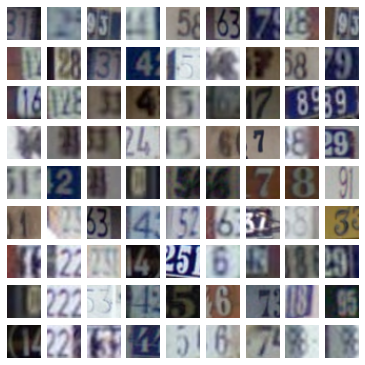

In [3]:
fig = plt.figure(figsize=(7, 7))
for x in range(1, 10):
    for y in range(1, 10):
        ax = fig.add_subplot(10, 10, 10*y+x)
        ax.imshow(data["X"][:, :, :, np.where(data["y"] == x)[0][y]])
        ax.axis("off")
        plt.xticks([])
        plt.yticks([])


### Labels
The dataset consists of images of digits from 0-9 extracted from house number images. The frequency distribution of the occurance of each digit is given as -

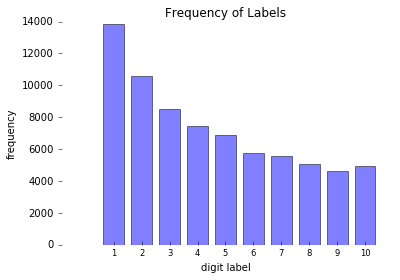

In [19]:
from collections import Counter

frequency = Counter(data["y"].reshape(-1).tolist())
x = np.arange(len(frequency.keys()))
width = .75
fig, ax = plt.subplots()
ax.set_frame_on(False)
ax.bar(x, frequency.values(), width, align = "center", edgecolor = "none", alpha = .5)
ax.set_xticks(x + width)
plt.xticks(range(0, 10), [str(i) for i in range(1, 11)], size="small")
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_title("Frequency of Labels")
ax.set_xlabel("digit label")
ax.set_ylabel("frequency");

## Preprocessing

- The shape of the dataset is changed from [x, y, color, example_number] to [example_number, x, y, color] for easy access.
- The data is normalized (x/128 - 1) to range [-1, 1]
- The original labels are 1-10 for digits 1,2,3,..9,0. Here, I'm changing the label for 0 to 0 instead of 10.

In [5]:
X_preprocessed = np.transpose(data["X"], [3, 0, 1, 2]) 
# 1-10 to 0-9
y_preprocessed = data["y"]
y_preprocessed[y_preprocessed == 10] = 0
num_labels = 10
y_preprocessed = y_preprocessed[:,0]
y_preprocessed = (np.arange(num_labels) == y_preprocessed[:, None]).astype(np.float32)
# y_preprocessed = label_binarize(data["y"], classes = range(10))

print "Shape of each training example: {0}".format(str(X_preprocessed[0, :, :, :].shape))
print "Shape of each training label :{0}".format(str(y_preprocessed[0].shape))

Shape of each training example: (32, 32, 3)
Shape of each training label :(10,)


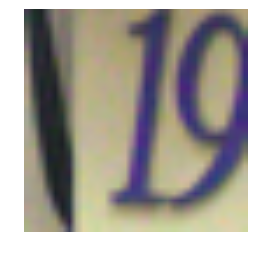

In [6]:
X_preprocessed = X_preprocessed.astype(np.float32) / 128.0 - 1

plt.axis("off")
plt.imshow(X_preprocessed[0, :, :, :]);

In [7]:
dataset = {
    "X": X_preprocessed,
    "y": y_preprocessed
}

data_file = "pickles/svhn.pickle"

with open(data_file, "wb") as f:
    pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)
    del dataset

In [20]:
data_file = "pickles/svhn.pickle"

with open(data_file, "rb") as f:
    dataset = pickle.load(f)
    X_preprocessed, y_preprocessed = dataset["X"], dataset["y"]
    del dataset

In [21]:
from sklearn.cross_validation import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_preprocessed.astype(np.float32), y_preprocessed.astype(np.float32))

In [22]:
print X_preprocessed.shape
print X_train.shape

(73257, 32, 32, 3)
(54942, 32, 32, 3)


## Building the CNN

The CNN consists of 3 convolutional layers and 2 fully connected layers.
Each convolutional layer is followed by a max pooling layer and its ouput is fed to ReLu.

There is a dropout layer between the 2 fully connected layers.

The input is a batch of 32x32 images with 3 channels (RGB) and the output is a one-hot encoded vector representing the predicted digit [0, 9].

In [2]:

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding="SAME")
    
    
graph = tf.Graph()

with graph.as_default():
    input_shape = [32, 32, 3]
    output_shape = [10]
    stddev = 0.1

    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.float32, [None, 10])
    keep_prob = tf.placeholder(tf.float32)
    
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-4, global_step=global_step, decay_steps=10000, decay_rate=0.97)


    weights = {
        "wc1": weight_variable([5, 5, 3, 96]),
        "wc2": weight_variable([5, 5, 96, 128]),
        "wc3": weight_variable([5, 5, 128, 256]),
        "wd1": weight_variable([4 * 4 * 256, 1024]),
        "wd2": weight_variable([1024, 10])
    }

    biases = {
        "bc1": bias_variable([96]),
        "bc2": bias_variable([128]),
        "bc3": bias_variable([256]),
        "bd1": bias_variable([1024]),
        "bd2": bias_variable([10])
    }

    def conv_net(X, weights, biases, keep_prob):
        X_reshaped = tf.reshape(X, shape = [-1, 32, 32, 3])
        conv1 = tf.nn.relu(conv2d(X_reshaped, weights["wc1"]) + biases["bc1"])
        pool1 = max_pool_2x2(conv1)
        
        conv2 = tf.nn.relu(conv2d(pool1, weights["wc2"]) + biases["bc2"])
        pool2 = max_pool_2x2(conv2)
        
        conv3 = tf.nn.relu(conv2d(pool2, weights["wc3"]) + biases["bc3"])
        pool3 = max_pool_2x2(conv3)

        pool3_flat = tf.reshape(pool3, [-1, 4 * 4 * 256])

        dense1 = tf.nn.relu(tf.matmul(pool3_flat, weights["wd1"]) + biases["bd1"])

        dropout = tf.nn.dropout(dense1, keep_prob)

        dense2 = tf.matmul(dropout, weights["wd2"]) + biases["bd2"]

        return dense2
    
    
    prediction = conv_net(X, weights, biases, keep_prob)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(prediction, y))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step)
    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    saver = tf.train.Saver()

In [15]:
print y_train.shape

(54942, 32, 32, 3)


## Training

For training, I'm feeding the data to the optimizer in 250 batches of 64 image-label pairs each. This process is repeated of 40 epochs. 

The training cost, training time, training accuracy and cross validation accuracy for each epoch is recorded.

Once the training is complete, the values of variables associated with the model are saved to disk.

In [26]:
n_epochs = 40
batch_size = 64
n_batches = 250 # int(X_train.shape[0] / batch_size)

np.random.seed(0)

with tf.Session(graph=graph) as sess:
    sess.run(tf.initialize_all_variables())
    headers = ["s_no", "time", "cost", "train_accuracy", "cv_accuracy"]
    print "|{0:>5} | {1:>10} | {2:>10} | {3:>15} | {4:>15} |".format(*headers)
    print "|{0:-<5} | {0:-<10} | {0:-<10} | {0:-<15} | {0:-<15} |".format("")
    
    for epoch in range(n_epochs):
        start_time = datetime.now()
        avg_cost = 0.0
        for _ in range(n_batches):
            indices = np.random.randint(X_train.shape[0], size=batch_size)
            train_step.run({ X: X_train[indices, :, :], y: y_train[indices, :], keep_prob: .9 })
            avg_cost += sess.run(cost, { X: X_train[indices, :, :], y: y_train[indices, :],  keep_prob: .9 }) / float(n_batches)
        
        indices = np.random.randint(X_train.shape[0], size=batch_size)
        score_train = sess.run(accuracy, { X: X_train[indices, :, :], y: y_train[indices, :],  keep_prob: 1})
        
        indices = np.random.randint(X_valid.shape[0], size=batch_size)
        score_valid = sess.run(accuracy, { X: X_valid[indices, :, :], y: y_valid[indices, :],  keep_prob: 1 })
        
        end_time = datetime.now()
        print ("|{0:>5} | {1:>6.3} min | {2:>10.2f} | {3:>13.1f} % | {4:>13.1f} % | ".format(
                 epoch + 1, (end_time - start_time).total_seconds() / 60.0, avg_cost, 100 * score_train, 100 * score_valid))
    save_path = saver.save(sess, "saved_models/SVHN_MODEL.ckpt")

| s_no |       time |       cost |  train_accuracy |     cv_accuracy |
|----- | ---------- | ---------- | --------------- | --------------- |
|    1 |   14.6 min |      10.70 |          32.8 % |          43.8 % | 
|    2 |   14.9 min |       2.85 |          46.9 % |          46.9 % | 
|    3 |   14.6 min |       1.78 |          57.8 % |          59.4 % | 
|    4 |   14.5 min |       1.38 |          65.6 % |          68.8 % | 
|    5 |   14.6 min |       1.18 |          54.7 % |          65.6 % | 
|    6 |   14.6 min |       1.06 |          70.3 % |          56.2 % | 
|    7 |   14.6 min |       0.93 |          76.6 % |          56.2 % | 
|    8 |   14.7 min |       0.80 |          67.2 % |          73.4 % | 
|    9 |   14.7 min |       0.75 |          90.6 % |          70.3 % | 
|   10 |   14.7 min |       0.70 |          85.9 % |          73.4 % | 
|   11 |   14.5 min |       0.63 |          85.9 % |          82.8 % | 
|   12 |   14.5 min |       0.59 |          84.4 % |          78.1

## Testing

I'll load the SVHN test dataset and run the trained CNN classifier on them.


In [4]:
test_dataset = scipy.io.loadmat("/home/saurabh/Documents/python/digits/data/mldata/test_32x32.mat")

print "The data has {0} labelled images.".format(test_dataset["X"].shape[3])

The data has 26032 labelled images.


Shape of each training example: (32, 32, 3)
Shape of each training label :(10,)


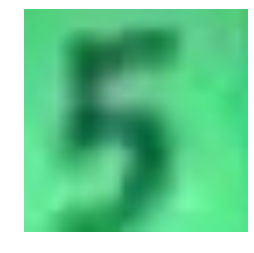

In [5]:
test_data = np.transpose(test_dataset["X"], [3, 0, 1, 2]) 
test_data = test_data.astype(np.float32) / 128.0 - 1

# 1-10 to 0-9
test_labels = test_dataset["y"]
test_labels[test_labels == 10] = 0
num_labels = 10
test_labels = test_labels[:,0]
test_labels = (np.arange(num_labels) == test_labels[:, None]).astype(np.float32)

print "Shape of each training example: {0}".format(str(test_data[0, :, :, :].shape))
print "Shape of each training label :{0}".format(str(test_labels[0].shape))

plt.axis("off")
plt.imshow(test_data[0, :, :, :]);

In [11]:
batch_size = 500
with tf.Session(graph=graph) as session:
    saver.restore(session, "saved_models/SVHN_MODEL.ckpt")
    test_accuracy = []
    for i in xrange(len(test_labels)/batch_size):
        batch_data = test_data[i * batch_size: (i * batch_size) + batch_size]
        batch_labels = test_labels[i * batch_size: (i * batch_size) + batch_size, :]
        test_accuracy.append(accuracy.eval(feed_dict={
                    X: batch_data, 
                    y: batch_labels,
                    keep_prob: 1.0}))
        print "Current batch : {0:.2f} %".format(test_accuracy[-1] * 100)
    print "Test accuracy : {0:.2f} %".format(np.mean(test_accuracy) * 100)

Current batch : 86.00 %
Current batch : 82.80 %
Current batch : 83.40 %
Current batch : 85.00 %
Current batch : 85.20 %
Current batch : 84.60 %
Current batch : 85.00 %
Current batch : 88.20 %
Current batch : 84.80 %
Current batch : 86.80 %
Current batch : 86.40 %
Current batch : 81.00 %
Current batch : 88.20 %
Current batch : 87.00 %
Current batch : 84.80 %
Current batch : 85.60 %
Current batch : 83.60 %
Current batch : 84.20 %
Current batch : 85.80 %
Current batch : 88.80 %
Current batch : 83.20 %
Current batch : 85.00 %
Current batch : 84.80 %
Current batch : 85.60 %
Current batch : 85.40 %
Current batch : 85.40 %
Current batch : 87.80 %
Current batch : 89.00 %
Current batch : 81.40 %
Current batch : 83.80 %
Current batch : 86.60 %
Current batch : 85.00 %
Current batch : 87.00 %
Current batch : 84.40 %
Current batch : 86.80 %
Current batch : 81.20 %
Current batch : 87.00 %
Current batch : 83.80 %
Current batch : 85.80 %
Current batch : 82.00 %
Current batch : 84.60 %
Current batch : 